In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scirpy as ir
import muon as mu

In [2]:
mdata = mu.read("/Users/jerryaaaaaa/scTCR_merged_res0.2.h5mu")

/opt/miniconda3/lib/python3.12/site-packages/anndata/utils.py:334: ExperimentalFeatureWarning: Support for Awkward Arrays is currently experimental. Behavior may change in the future. Please report any issues you may encounter!
  warnings.warn(msg, category, stacklevel=stacklevel)


In [ ]:
def combined_tcr_gex_metadata(mdata, gex_mod="gex", tcr_mod="airr", genes=None):
    gex_obs = mdata[gex_mod].obs.copy()
    tcr_obs = mdata[tcr_mod].obs[["clone_id"]].copy()

    adata_gex = mdata[gex_mod]
    if genes is None:
        genes_use = adata_gex.var_names.tolist()
    else:
        genes_use = [g for g in genes if g in adata_gex.var_names]
        if not genes_use:
            raise ValueError("None of the requested genes are present in var_names!")
    X = adata_gex[:, genes_use].X
    if hasattr(X, "toarray"):
        X = X.toarray()
    gex_df = pd.DataFrame(X, index=adata_gex.obs_names, columns=genes_use)

    combined_obs = gex_obs.join(tcr_obs, how="left")

    combined = pd.concat([combined_obs, gex_df], axis=1)

    return combined

In [3]:
#Identifiy frequent T-cell clones
clone_counts = mdata["airr"].obs["clone_id"].value_counts()
frequent_clones = clone_counts[clone_counts >= 5].index.tolist()

In [4]:
#Subset RNA data to frequent clones, without altering original data
adata_filtered = mdata["gex"][mdata["airr"].obs["clone_id"].isin(frequent_clones)].copy()

In [5]:
adata_filtered

AnnData object with n_obs × n_vars = 4547 × 21941
    obs: 'n_genes', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'scaled'
    obsp: 'connectivities', 'distances'

In [6]:
#Subset whole data
mdata_filtered = mdata[mdata["airr"].obs["clone_id"].isin(frequent_clones)].copy()

In [7]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.14.0 pandas==2.2.2 scikit-learn==1.5.1 statsmodels==0.14.2 igraph==0.11.5 pynndescent==0.5.13


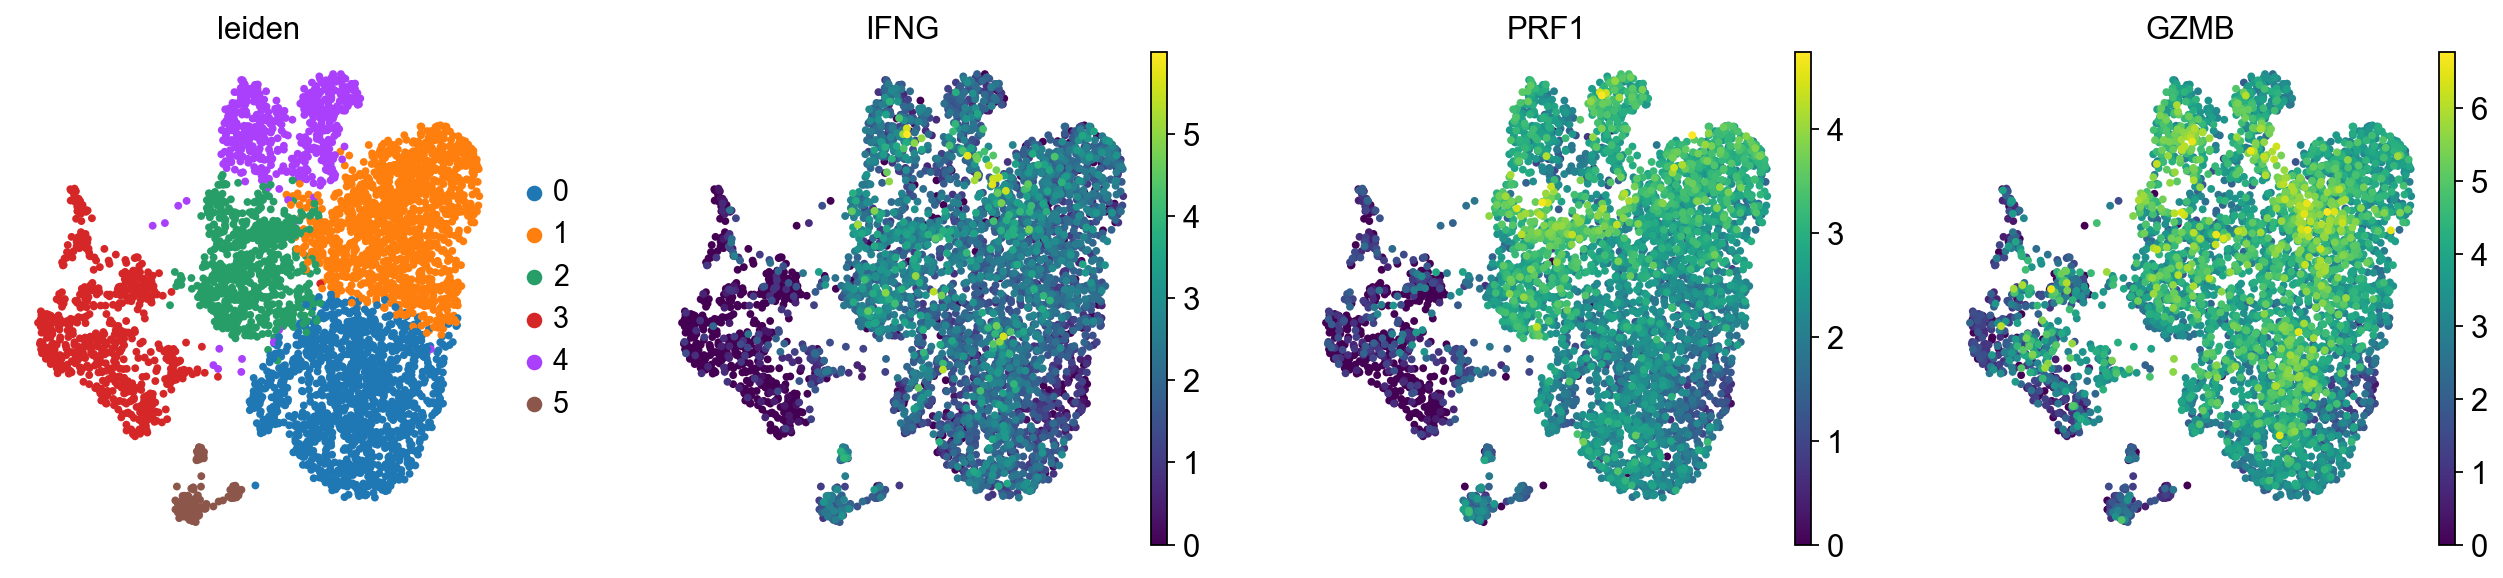

In [8]:
sc.pl.umap(mdata_filtered["gex"], color=["leiden", "IFNG", "PRF1", "GZMB"], frameon=False, size=50)

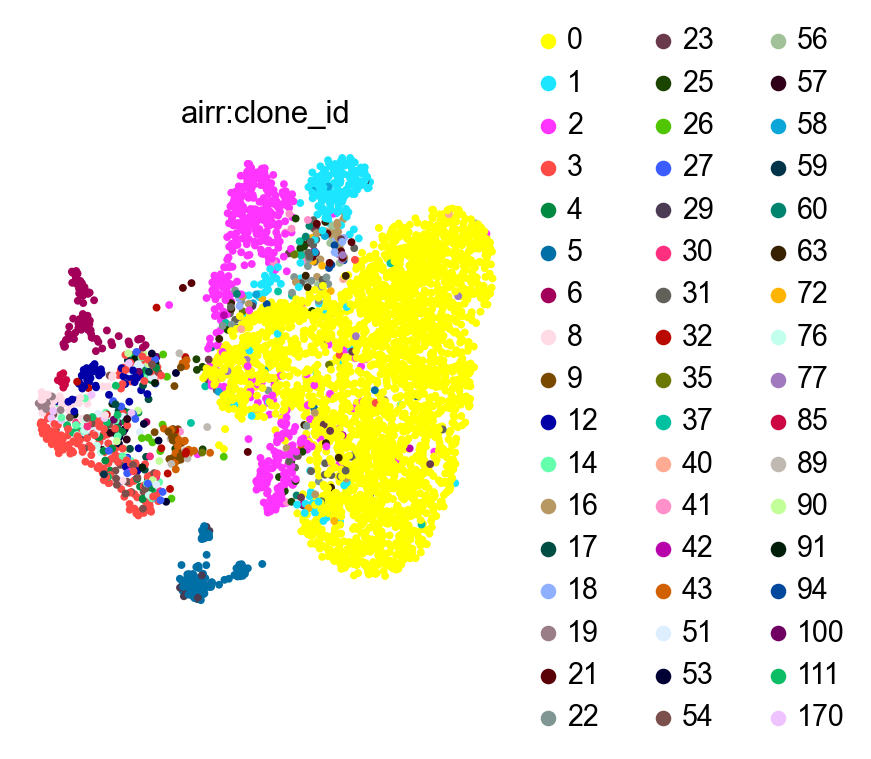

In [9]:
mu.pl.embedding(
    mdata_filtered,
    basis="gex:umap",
    color="airr:clone_id",
    size=50,
    frameon = False
)

In [10]:
cdr3_info = ir.get.airr(
    mdata_filtered["airr"], 
    airr_variable=["cdr3_aa"],
    chain=["VJ_1", "VDJ_1"],
    )

In [11]:
clone_info = mdata_filtered["airr"].obs[["clone_id"]].copy()

In [12]:
tcr_info = clone_info.join(cdr3_info, how="inner")

In [13]:
gex = mdata_filtered["gex"].copy()
gex_df = pd.DataFrame(
    gex.X.toarray() if hasattr(gex.X, "toarray") else gex.X,
    index=gex.obs_names,
    columns=gex.var_names
)

In [14]:
combined_df = tcr_info.join(gex_df, how="inner")
combined_df.reset_index(inplace=True)
combined_df = combined_df.rename(columns={"index": "cell_id", "VJ_1_cdr3_aa": "alpha_cdr3_aa", "VDJ_1_cdr3_aa": "beta_cdr3_aa"})

In [15]:
combined_df["alpha_cdr3_length"] = combined_df["alpha_cdr3_aa"].str.len()
combined_df["beta_cdr3_length"] = combined_df["beta_cdr3_aa"].str.len()
combined_df["leiden"] = mdata_filtered["gex"].obs["leiden"].values
combined_df

,cell_id,clone_id,alpha_cdr3_aa,beta_cdr3_aa,ENSG00000238009,ENSG00000241860,ENSG00000290385,ENSG00000291215,LINC01409,ENSG00000290784,...,MAFIP,ENSG00000276256,ENSG00000278384,ENSG00000273748,ENSG00000271254,ENSG00000276345,ENSG00000277196,alpha_cdr3_length,beta_cdr3_length,leiden
0,AAACCTGAGAATGTTG-1,0,AMPVVDLLTGGADGLT,ASSVEPQLAGRGDTQY,-0.049227,-0.057389,-0.093586,0.286578,0.319260,-0.186367,...,0.910057,1.031487,-0.055752,0.546428,-0.067478,-0.042003,-0.039438,16.0,16,0
1,AAACCTGAGGTAGCTG-1,0,AMPVVDLLTGGADGLT,ASSVEPQLAGRGDTQY,-0.049227,-0.057389,-0.093586,-0.372756,-0.331338,-0.186367,...,-0.235851,-0.223091,-0.055752,3.628933,-0.067478,-0.042003,-0.039438,16.0,16,1
2,AAACCTGAGTAGATGT-1,1,APLGNEKLT,ASSYYRPTGPYEQY,-0.049227,-0.057389,-0.093586,-0.372756,-0.331338,-0.186367,...,-0.235851,-0.223091,-0.055752,-0.276691,-0.067478,-0.042003,-0.039438,9.0,14,4
3,AAACCTGAGTGGAGTC-1,0,AMPVVDLLTGGADGLT,ASSVEPQLAGRGDTQY,-0.049227,-0.057389,-0.093586,-0.372756,-0.331338,-0.186367,...,-0.235851,-0.223091,-0.055752,-0.276691,-0.067478,-0.042003,-0.039438,16.0,16,1
4,AAACCTGCAGACAAGC-1,0,AMPVVDLLTGGADGLT,ASSVEPQLAGRGDTQY,-0.049227,-0.057389,-0.093586,2.837751,-0.331338,-0.186367,...,-0.235851,-0.223091,-0.055752,-0.276691,-0.067478,-0.042003,-0.039438,16.0,16,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4542,TTTGTCACATCGACGC-1,0,AMPVVDLLTGGADGLT,ASSVEPQLAGRGDTQY,-0.049227,-0.057389,-0.093586,-0.372756,-0.331338,-0.186367,...,-0.235851,-0.223091,-0.055752,6.055794,-0.067478,-0.042003,-0.039438,16.0,16,1
4543,TTTGTCAGTTGGAGGT-1,0,AMPVVDLLTGGADGLT,ASSVEPQLAGRGDTQY,-0.049227,-0.057389,-0.093586,-0.372756,-0.331338,-0.186367,...,-0.235851,-0.223091,-0.055752,-0.276691,-0.067478,-0.042003,-0.039438,16.0,16,0
4544,TTTGTCATCACAACGT-1,111,ATVPMFSGGYNKLI,ASTLLRGEQF,-0.049227,-0.057389,-0.093586,-0.372756,-0.331338,-0.186367,...,-0.235851,-0.223091,-0.055752,-0.276691,-0.067478,-0.042003,-0.039438,14.0,10,3
4545,TTTGTCATCCAAATGC-1,3,ATQLYNARLM,ASSARGTKNIQY,-0.049227,-0.057389,-0.093586,-0.372756,-0.331338,-0.186367,...,-0.235851,-0.223091,-0.055752,-0.276691,-0.067478,-0.042003,-0.039438,10.0,12,3


In [16]:
mdata_filtered["gex"]

AnnData object with n_obs × n_vars = 4547 × 21941
    obs: 'n_genes', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap', 'airr:clone_id_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'scaled'
    obsp: 'connectivities', 'distances'

In [18]:
#Check if gene expression is normalized/scaled
genes_to_check = ["IFNG", "GZMB", "PRF1"]
gene_indices = [np.where(mdata_filtered["gex"].var_names == gene)[0][0] for gene in genes_to_check]

result = {}
for gene, idx in zip(genes_to_check, gene_indices):
    vals = mdata_filtered["gex"].x[:, idx].toarray().flatten() if hasattr(mdata_filtered["gex"].X, "toarray") else mdata_filtered["gex"].X[:, idx]
    result[gene] = {
        "mean": np.mean(vals),
        "std": np.std(vals),
        "min": np.min(vals),
        "max": np.max(vals)
    }
pd.DataFrame(result).T

,mean,std,min,max
IFNG,0.049444,0.975429,-1.521752,4.163163
GZMB,0.027979,0.971050,-2.622092,2.531547
PRF1,0.067145,0.963118,-2.047616,2.691355


In [22]:
combined_df.to_csv("/Users/jerryaaaaaa/tcr_gex_meta.csv", index=False)